# 감성분석 모델 구축

In [ ]:
# ! pip install scikit-learn
# ! pip install konlpy

In [ ]:
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# from konlpy.tag import Mecab
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings(action = 'ignore') # warning 메시지 표시x

### 2. 훈련모델Ⅱ - 200,000개 + 14,060개
- 네이버 쇼핑 리뷰로 훈련(train)
- 쿠팡리뷰로 평가(test)

In [2]:
naver_for_train = pd.read_excel('(0)naver_reviews.xlsx')
coupang_for_test = pd.read_excel('(3)coupang_reviews.xlsx')

# 0. 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
print('훈련용 리뷰의 개수 :', len(naver_for_train))
print('테스트용 리뷰의 개수 :', len(coupang_for_test))
# 훈련용 리뷰의 개수 : 200,000개
# 테스트용 리뷰의 개수 : 14,060

# 1. 라벨 분포 확인
naver_for_train['label'].value_counts() # 0: 100037 & 1: 99963
coupang_for_test['label'].value_counts() # 1: 13489 & 0: 571

# 2. 한글 외의 문자 제거
naver_for_train['reviews'] = naver_for_train['reviews'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
coupang_for_test['reviews'] = coupang_for_test['reviews'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))

# naver_for_train.head()
# coupang_for_test.head()

훈련용 리뷰의 개수 : 200000
테스트용 리뷰의 개수 : 14060


In [3]:
# 3. 분석 모델 구축 전 작업

# 1)형태소 분석 - 문장을 토큰화
okt = Okt()
def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

# 2)TF-IDF 벡터화에 사용할 tfidf 객체 생성 -> 벡터로 변환(transform)
tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf.fit(naver_for_train['reviews'])
model2_train_tfidf = tfidf.transform(naver_for_train['reviews'])
model2_train_tfidf

# 19분

<200000x158594 sparse matrix of type '<class 'numpy.float64'>'
	with 4231021 stored elements in Compressed Sparse Row format>

In [4]:
# 4. 분석 모델 구축

SA_lr = LogisticRegression(random_state=0)
SA_lr.fit(model2_train_tfidf, naver_for_train['label'])

params = {'C': [1,3,3.5,4,4.5,5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)

SA_lr_grid_cv.fit(model2_train_tfidf, naver_for_train['label'])

print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

SA_lr_best2 = SA_lr_grid_cv.best_estimator_ 

# {'C': 3.5} 0.9153

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'C': 3.5} 0.9153


In [5]:
# 5. 분석 모델 평가1 - 평가용 데이터를 이용하여 모델 정확도 확인하기

model2_test_tfidf = tfidf.transform(coupang_for_test['reviews'])

test_predict = SA_lr_best2.predict(model2_test_tfidf)

# 평가용 데이터의 감성 결과값nsmc_test_df['label']과 감성 예측값test_predict을 기반으로 정확도를 계산accuracy_score( )하여출력

print('감성 분석 모델의 정확도 : ', round(accuracy_score(coupang_for_test['label'], test_predict), 3))
# 감성 분류 모델의 정확도가 65.2%!
# * -> 각종 상품군으로 훈련시키고, 정작 평가는 무선 이어폰으로만 진행했으니, 모델 정확도가 낮아짐
    # 선호하는 키워드들이 다르므로

감성 분석 모델의 정확도 :  0.652


## => 감성 분석 정확도가 낮게 나왔으므로,
- 이러한 현상이 나타난 이유에 관한 분석을 해야 한다
- 키워드 빈도 분석을 비교하고, 이를 보기 편하게 시각화로 ㄱㄱ
- 1)네이버 쇼핑 리뷰 키워드 분석 -> 긍/부정
- 2)쿠팡 리뷰 키워드 분석 -> 긍/부정

### 1)쿠팡 리뷰 키워드 분석 - 시각화

In [12]:
columns_name = ['ratings', 'reviews', 'label']
coupang_neg = pd.DataFrame(columns = columns_name)
coupang_pos = pd.DataFrame(columns = columns_name)

for i, data in coupang_for_test.iterrows():
    ratings = data["ratings"]
    reviews = data["reviews"]
    label = data["label"]

    if label == 0: # 부정 감성 샘플
        coupang_neg = coupang_neg._append(pd.DataFrame([[ratings, reviews, label]],columns = columns_name), ignore_index = True)
    else : # 긍정 
        coupang_pos = coupang_pos._append(pd.DataFrame([[ratings, reviews, label]], columns = columns_name), ignore_index = True)
    

coupang_neg.to_excel('coupang_neg.xlsx', index=False)
coupang_pos.to_excel('coupang_pos.xlsx', index=False)

In [13]:
# Step1: 긍정 리뷰에서 명사 단어 추출하기
POS_description = coupang_pos['reviews'] 
POS_description_noun_tk = [] # tk는 토큰

for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d)) # 명사 형태소만. 추출
# POS_description_noun_tk

# 하나의 기사는: 하나의 str으로 + ','대신에 띄어쓰기로 
POS_description_noun_join = []

for d in POS_description_noun_tk:
    d2 = [w for w in d if len(d)>1] # 토큰 길이 1은 없애기
    POS_description_noun_join.append(" ".join(d2))

len(POS_description_noun_join) # 13500여개

['가성 비 갑 성능 추천 돈 산 후기 구매 및 개봉일 월 구매 사유 기존 블루투스 이어폰 한쪽 분실 다음 날 여행 출발 일이 구매 해당 제품 선택 사유 브랜드 갤럭시 종 갤럭시 버즈 사고 갤럭시 버즈 버즈 버즈 등등 정말 고민 일단 저 를 쓰기 이어폰 자주 편이 과소 비일 것 제외 버즈 버즈 가격 차이나 성능 면 차이 더욱 고민 우선 가격 만원 정도 차이 더 성능 경우 보급 인식 때문 성능 별로 인식 좀 실제 때 우선 버즈 배터리 시간 버즈 노이즈 캔 슬링 사용 준수 다만 착용 개인 귀가 좀 고무 패킹 변경 수 버즈 의 경우 직접 사용 음질 버즈 더 가격 측면 기능 가성 비 때 버즈 저 더 합리 구매 사용 후기 택배 도착 후 뽁뽁이 상자 개봉 뒤쪽 위아래 부분 선 직접 제거 개봉 겉 화이트 색 케이스 내부 버드 블랙 완전 블랙 연한 블랙 블랙 그레이 설명 고무 패킹 충 전용 선 어댑터 성품 모두 도착 충 전용 선 타입 사진 양쪽 타입 갤럭시 사용자 타입 용 어댑터 선 컴퓨터 본체 보조 배터리 충전 수 휴대폰 화면 첨부 사진 기차 노이즈 캔 슬링 사용 생각 성능 오히려 사람 말소리 차안 방송 또 정도 가성 비 갑 수 구매 추천 후기 도움 도움 버튼',
 '전직 컴 수리 기사 버즈 테스트 결과 보고서 주 문 도 착 제 품 갤럭시 버즈 블루투스 화이트 블투 개정 버즈 에어팟 외 중소 메이커 거중 체험 등등 젠 블투 전문가 컴 수리 기사 여러분 그 후기 정리 보고서 도움 핸드폰 로 걸 후반 핸드폰 작업 일이 종 쿠팡 리뷰 동영상 편',
 '가성 비 자체 무선 이어폰 돈 산 솔직 후기 매일 달 가량 사용 솔직 후기 장점 편안함 커널 타입 보청기 귓 구멍 내 삽입 사용 형태 외부 오픈 이어폰 런닝 격 운동 배터리 용량 귀 끼 사용 시제 사용 버즈 시간 시간 시간 좀더 사용 수 통화시 시간 분 노이즈 캔 슬링 외부 소음 소리 방 음악 느낌 바람 불 거리 를 기반 주변 소음 기능 덕분 언제 어디 서나 통화 버드 찾기 기능 가끔 무언 케이스 채 책상 곤 어딘가 때 버드 찾기

In [14]:
# Step2: 부정 리뷰에서 명사 추출
NEG_description = coupang_neg['reviews']
NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #명사 형태소만 추출
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1보다 큰 토큰만 추출
    NEG_description_noun_join.append(" ".join(d2)) # 토큰 연결하여 리스트 구성

len(NEG_description_noun_join) # 길이: 571

571

In [23]:
# Step3: TF-IDF 기반 DTM 구성하기 -> 긍정
POS_tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, min_df=2)
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

POS_vocab = dict()
for idx, word in enumerate(POS_tfidf.get_feature_names_out()): # tfidf는 get-~out()함수로 꺼내올 수 있다
    # DTM의 단어get_feature_names()마다 컬럼의 합 getcol(idx).sum( )을 구하여 단어별 TFIDF 값의 합을 구하기
    POS_vocab[word] = POS_dtm.getcol(idx).sum()

POS_words = sorted(POS_vocab.items(), key = lambda x: x[1], reverse = True)

POS_words = POS_words[6:]
POS_words

In [25]:
# Step3-2: 부정
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df = 2)
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

NEG_vocab = dict()
for idx, word in enumerate(NEG_tfidf.get_feature_names_out()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
NEG_words = sorted( NEG_vocab.items(), key = lambda x: x[1], reverse = True)


NEG_words = NEG_words[4:]
NEG_words

[('소리', 21.822213210719212),
 ('교환', 21.699666006791645),
 ('충전', 20.711223903823246),
 ('사용', 19.1997295191318),
 ('버즈', 18.598699000484654),
 ('이어폰', 18.00000298822997),
 ('구매', 17.267260401255502),
 ('불량', 16.36536055145628),
 ('음질', 15.705733373276056),
 ('연결', 15.469379578184181),
 ('왼쪽', 15.388774015884454),
 ('그냥', 14.906331276205059),
 ('착용', 14.491995350101686),
 ('진짜', 13.591950050032338),
 ('박스', 13.572416871092331),
 ('프로', 13.379039391641829),
 ('리뷰', 12.877166511826168),
 ('상품', 12.79659471046888),
 ('오른쪽', 12.735033765775006),
 ('통화', 12.14355023827898),
 ('배송', 11.853741735369697),
 ('케이스', 11.357166755421126),
 ('용이', 10.88364115308769),
 ('문제', 10.865940745423782),
 ('쿠팡', 10.835807864280858),
 ('센터', 10.557446105028813),
 ('한쪽', 10.262598057774042),
 ('포장', 10.240851133005842),
 ('노이즈', 10.19780785017241),
 ('생각', 10.006530605762006),
 ('정도', 9.882556874434002),
 ('반품', 9.855774305824166),
 ('가격', 9.828885552895159),
 ('배터리', 9.319446278348094),
 ('애플', 9.10049869447

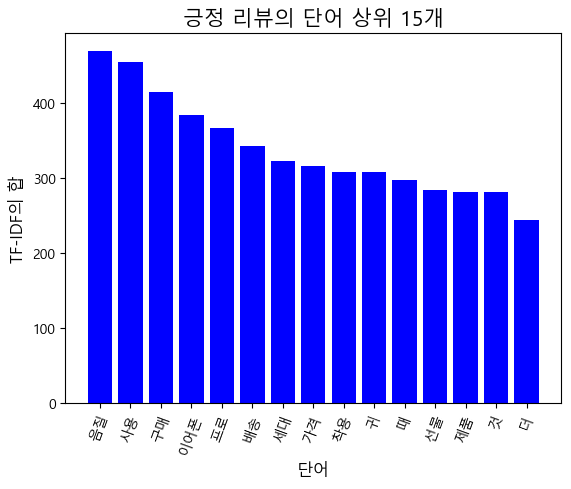

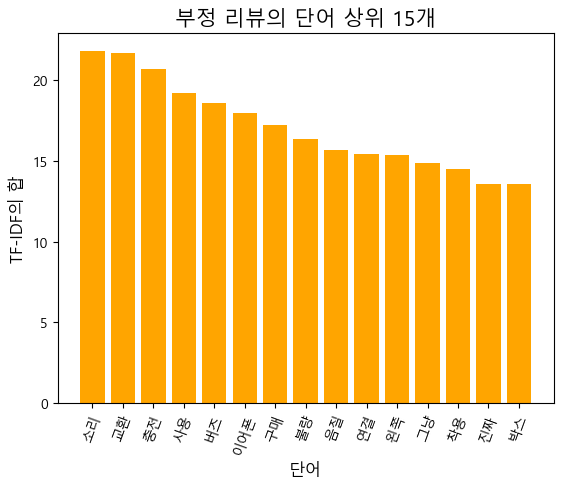

In [26]:
# Step4: 시각화 - 긍정/부정
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm._get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)
max = 15 # 바 차트에 나타낼 단어 수

plt.bar(range(max), [i[1] for i in POS_words[:max]], color='blue')
plt.title("쿠팡 - 긍정 리뷰의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)
plt.show()

# Step4-2: 부정뉴스
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color = "orange")
plt.title("쿠팡 - 부정 리뷰의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation = 70)
plt.show()


### 2)네이버 리뷰 키워드 분석 - 시각화

In [28]:
columns_name = ['ratings', 'reviews', 'label']
naver_neg = pd.DataFrame(columns = columns_name)
naver_pos = pd.DataFrame(columns = columns_name)

for i, data in naver_for_train.iterrows():
    ratings = data["ratings"]
    reviews = data["reviews"]
    label = data["label"]

    if label == 0: # 부정 감성 샘플
        naver_neg = naver_neg._append(pd.DataFrame([[ratings, reviews, label]],columns = columns_name), ignore_index = True)
    else : # 긍정 
        naver_pos = naver_pos._append(pd.DataFrame([[ratings, reviews, label]], columns = columns_name), ignore_index = True)
    

naver_neg.to_excel('naver_neg.xlsx', index=False)
naver_pos.to_excel('naver_pos.xlsx', index=False)

In [29]:
# Step1: 긍정 명사 단어 추출하기
POS_description = naver_pos['reviews'] 
POS_description_noun_tk = [] # tk는 토큰
POS_description_noun_join = []

for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d)) # 명사 형태소만. 추출

for d in POS_description_noun_tk:
    d2 = [w for w in d if len(d)>1] # 토큰 길이 1은 없애기
    POS_description_noun_join.append(" ".join(d2))

len(POS_description_noun_join) # 99963

99963

In [30]:
# Step2: 부정 리뷰에서 명사 추출
NEG_description = naver_neg['reviews']
NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #명사 형태소만 추출
    
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1보다 큰 토큰만 추출
    NEG_description_noun_join.append(" ".join(d2)) # 토큰 연결하여 리스트 구성

len(NEG_description_noun_join) # 100037

100037

In [37]:
# Step3: TF-IDF 기반 DTM 구성하기 -> 긍정
POS_tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, min_df=2)
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

POS_vocab = dict()
for idx, word in enumerate(POS_tfidf.get_feature_names_out()): # tfidf는 get-~out()함수로 꺼내올 수 있다
    # DTM의 단어get_feature_names()마다 컬럼의 합 getcol(idx).sum( )을 구하여 단어별 TFIDF 값의 합을 구하기
    POS_vocab[word] = POS_dtm.getcol(idx).sum()

POS_words = sorted(POS_vocab.items(), key = lambda x: x[1], reverse = True)

POS_words = POS_words[:30] # 30개까지 보고, 필요없는거 추려내서 의미있는 상위15개 고르기
remove_index = [10,11,12,14,15,16,22]
POS_words = [item for idx, item in enumerate(POS_words) if idx not in remove_index]
POS_words

[('배송', 3948.4644474988318),
 ('구매', 2212.6004551412434),
 ('가격', 1912.7791613913976),
 ('사용', 1860.8267681893649),
 ('제품', 1623.3563397605262),
 ('주문', 1356.0877536283976),
 ('생각', 1334.6042280603274),
 ('맛', 1280.8763155330573),
 ('아주', 1238.0822606911875),
 ('포장', 1197.2268531098414),
 ('사이즈', 1027.5474363646128),
 ('정말', 904.0841857561288),
 ('아이', 889.475123632156),
 ('항상', 863.232124170234),
 ('선물', 812.6213053579523),
 ('구입', 795.381230165794),
 ('가성', 773.1238444123205),
 ('상품', 768.8757258628801),
 ('비', 755.8636522220527),
 ('용', 747.7297641980814),
 ('디자인', 745.2187652950325),
 ('대비', 738.9554788264098),
 ('만족', 707.5674081452282)]

In [36]:
# Step3-2: 부정
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df = 2)
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

NEG_vocab = dict()
for idx, word in enumerate(NEG_tfidf.get_feature_names_out()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
NEG_words = sorted( NEG_vocab.items(), key = lambda x: x[1], reverse = True)

NEG_words = NEG_words[:30]
NEG_words

[('배송', 3535.4425755571956),
 ('그냥', 2634.2189180032833),
 ('별로', 2509.777093861198),
 ('생각', 2407.0894520991237),
 ('사용', 1680.0061521713465),
 ('제품', 1627.41155660257),
 ('가격', 1576.2430998040734),
 ('구매', 1376.8970319901662),
 ('사이즈', 1331.3737831647102),
 ('냄새', 1265.9128558071377),
 ('주문', 1158.1347219396941),
 ('부분', 1111.7246523567553),
 ('상품', 1109.8444892761327),
 ('반품', 1056.4113606056108),
 ('포장', 1029.986873810615),
 ('하나', 868.4599870872203),
 ('진짜', 848.2406141414386),
 ('효과', 791.0217423834578),
 ('정말', 737.9632267221804),
 ('조금', 737.2924079173712),
 ('느낌', 727.9032474504459),
 ('정도', 714.241484114734),
 ('실망', 705.0872786339356),
 ('상태', 677.543801626487),
 ('한번', 675.6139737173256),
 ('교환', 674.2224970863624),
 ('불량', 652.3010645490897),
 ('사진', 647.931388232382),
 ('완전', 643.2335229826818),
 ('다시', 623.4409737511412)]

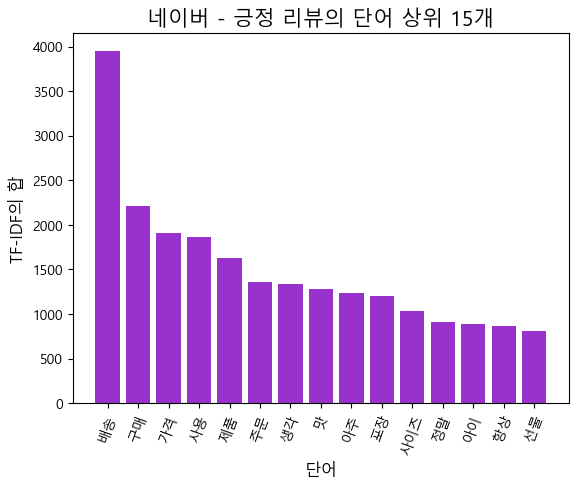

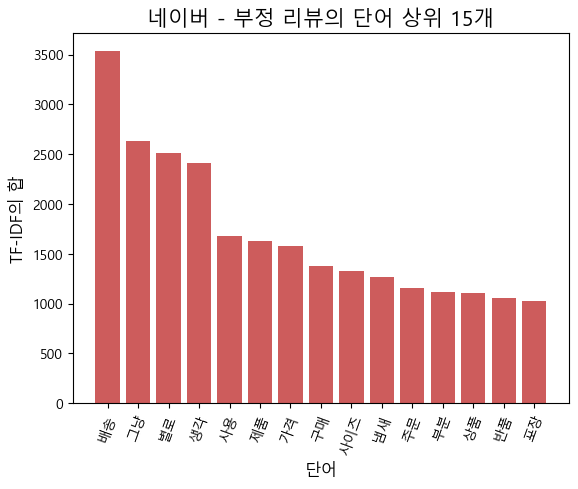

In [38]:
# Step4: 시각화 - 긍정/부정
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm._get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)
max = 15 # 바 차트에 나타낼 단어 수

plt.bar(range(max), [i[1] for i in POS_words[:max]], color='darkorchid')
plt.title("네이버 - 긍정 리뷰의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)
plt.show()

# Step4-2: 부정
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color = "indianred")
plt.title("네이버 - 부정 리뷰의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation = 70)
plt.show()
